In [1]:
from funcs.auroralring import AuroralRing
import numpy as np
import matplotlib.pyplot as plt

import emcee
import corner

# dark mode
plt.style.use('dark_background')

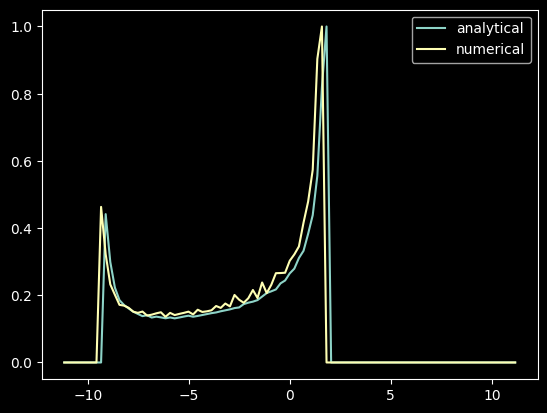

In [15]:
# set up the ring
ring = AuroralRing(i_rot=20/180*np.pi, i_mag=40 * np.pi/180, latitude=51.5*np.pi/180,
                   width=1 * np.pi/180, Rstar=1, P_rot=1.5 * np.pi, N=100, 
                   norm=11, gridsize=int(4e5))

# calculate the flux
alpha = 50 * np.pi/180

flux_analytical = ring.get_flux_analytically(alpha)

# calculate the flux 
# this serves as measurement
flux_numerical = ring.get_flux_numerically(alpha)
flux_err = np.ones_like(flux_numerical) * 0.05

plt.plot(ring.v_mids, flux_analytical, label='analytical')
plt.plot(ring.v_mids, flux_numerical, label='numerical')
plt.legend()

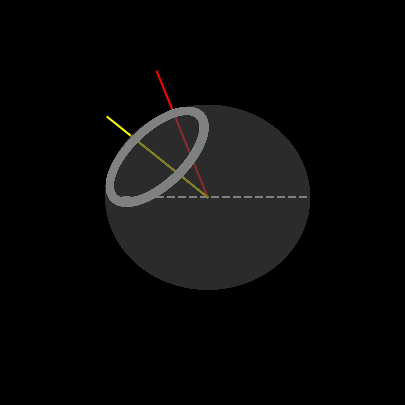

In [16]:
fig, ax = ring.plot_setup_sphere()

ring.plot_sphere_with_auroral_ring(ax, alpha=alpha)
ring.plot_layout_sphere(ax, view="observer left")
